In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

### Dataset Loading

In [2]:
import json, gzip

class MNIST_Dataset(Dataset):
    def __init__(self, json_data) -> None:
        self.features = [torch.FloatTensor(i['image']).view(28,28) for i in json_data]
        self.labels = [torch.LongTensor([i['label']]) for i in json_data]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = None
dev_dataset = None
test_dataset = None

with gzip.open('mnist_rowmajor.jsonl.gz') as file:
    trainval_data = []
    test_data = []

    for sample in [json.loads(line) for line in file]:
        sample['image'] = sample['image']
        if sample['split'] == 'train':
            trainval_data.append(sample)
        else:
            test_data.append(sample)

    train_dataset = MNIST_Dataset(trainval_data[:50000])
    dev_dataset = MNIST_Dataset(trainval_data[50000:])
    test_dataset = MNIST_Dataset(test_data)

In [3]:
BATCH_SIZE = 100

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Question 2b

In [4]:
class LinearAutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        z = self.encoder(x)
        return z
    
    def decode(self, z):
        pred_x = self.decoder(z)
        return pred_x
    
    def forward(self, x, detach = False):
        pred_x = self.decode(self.encode(x.view(-1,28*28)))
        if detach:
            pred_x = pred_x.cpu().detach()
        return pred_x.view(-1,28,28)

In [5]:
class ConvAutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(1, 5, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(5, 10, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1000, 10)
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 1000),
            nn.Unflatten(1, (10,10,10)),
            nn.ReLU(),
            nn.ConvTranspose2d(10, 5, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(5, 1, kernel_size=4, stride=2),
            nn.Sigmoid()
        )

    def encode(self, x):
        z = self.encoder(x)
        return z
    
    def decode(self, z):
        pred_x = self.decoder(z)
        return pred_x
    
    def forward(self, x, detach = False):
        pred_x = self.decode(self.encode(x.view(-1,1,28,28)))
        if detach:
            pred_x = pred_x.cpu().detach()
        return pred_x.view(-1,28,28)

In [6]:
def train_encoder(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, num_epoch = 1):
    print(f'{"":<10} {"Train":^10} {"Dev":^10}')
    # epoch loop
    for epoch in range(num_epoch):
        print(f'{f"Epoch {epoch+1}":<10}', end=' ')
        # 
        # training loop
        # 
        total_loss = 0
        total_num = 0
        for x, _ in train_dataloader:
            x = x.cuda()
            # forward pass
            pred_x = model.forward(x)
            # calculate gradients
            loss = criterion(pred_x, x)
            loss.backward()
            # update statistics
            total_loss += loss.item()
            total_num += 1
            # backward pass
            optimizer.step()
            optimizer.zero_grad()
        print(f'{total_loss/total_num:^10.5f}', end=' ')
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, _ in dev_dataloader:
            x = x.cuda()
            # forward pass
            pred_x = model.forward(x)
            # update statistics
            total_loss += criterion(pred_x, x).item()
            total_num += 1
        print(f'{total_loss/total_num:^10.5f}')

In [7]:
encoder_linear = LinearAutoEncoder().cuda()
train_encoder(encoder_linear, nn.BCELoss(), optim.Adam(encoder_linear.parameters(), lr=0.01), 10)

             Train       Dev    
Epoch 1     0.19105    0.14666  
Epoch 2     0.13803    0.13107  
Epoch 3     0.12870    0.12656  
Epoch 4     0.12472    0.12288  
Epoch 5     0.12264    0.12099  
Epoch 6     0.12142    0.12121  
Epoch 7     0.12063    0.12071  
Epoch 8     0.11970    0.12114  
Epoch 9     0.11939    0.11827  
Epoch 10    0.11892    0.11801  


In [8]:
encoder_conv = ConvAutoEncoder().cuda()
train_encoder(encoder_conv, nn.BCELoss(), optim.Adam(encoder_conv.parameters(), lr=0.01), 10)

             Train       Dev    
Epoch 1     0.16795    0.12991  
Epoch 2     0.12481    0.11992  
Epoch 3     0.11840    0.11630  
Epoch 4     0.11581    0.11523  
Epoch 5     0.11447    0.11354  
Epoch 6     0.11356    0.11314  
Epoch 7     0.11269    0.11264  
Epoch 8     0.11228    0.11170  
Epoch 9     0.11177    0.11172  
Epoch 10    0.11130    0.11147  


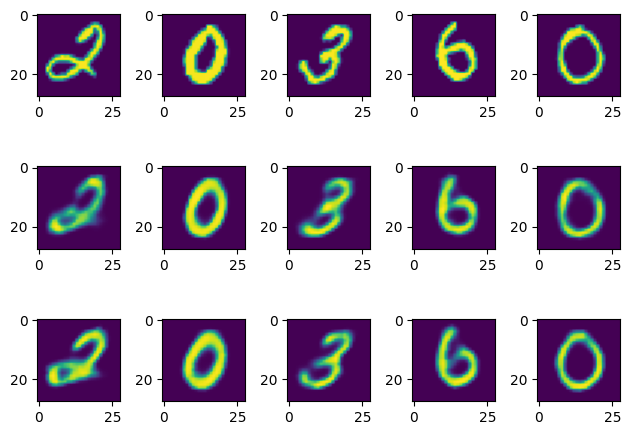

In [9]:
import random
fig, (row1, row2, row3) = plt.subplots(3, 5)

for i in range(5):
    x = dev_dataset[random.randint(0,10000-1)][0].cuda()
    x_pred_linear = encoder_linear.forward(x, detach=True).view(28,28)
    x_pred_conv = encoder_conv.forward(x, detach=True).view(28,28)

    row1[i].imshow(x.cpu())
    row2[i].imshow(x_pred_linear.cpu())
    row3[i].imshow(x_pred_conv.cpu())

plt.tight_layout()
plt.show()

### Question 2c

In [10]:
class BaselineClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = torch.zeros(10)
    
    def forward(self, x):
        pred_y = torch.zeros(x.shape[0], 10)
        pred_y[:,self.w.argmax()] = 1
        return pred_y

In [11]:
class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )
    
    def forward(self, x):
        return self.layers(x.view(-1,28*28))

In [12]:
def train_baseline(model: BaselineClassifier, criterion: nn.Module, num_epoch = 1):
    print(f'{"":<10} {"Train":^10} {"Test":^10}')
    # epoch loop
    for epoch in range(num_epoch):
        print(f'{f"Epoch {epoch+1}":<10}', end=' ')
        # 
        # training loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in train_dataloader:
            x = x.cuda()
            y = y.view(-1)
            # forward pass
            pred_y = model.forward(x)
            # update statistics
            total_loss += criterion(pred_y, y).item()
            total_num += 1
            # backward pass
            for y_i in y:
                model.w[y_i] += 1
        print(f'{total_loss/total_num:^10.5f}', end=' ')
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in test_dataloader:
            x = x.cuda()
            y = y.view(-1)
            # forward pass
            pred_y = model.forward(x)
            # update statistics
            total_loss += criterion(pred_y, y).item()
            total_num += 1
        print(f'{total_loss/total_num:^10.5f}')

In [13]:
def train_classifier(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, num_epoch = 1):
    print(f'{"":<10} {"Train":^10} {"Test":^10}')
    # epoch loop
    for epoch in range(num_epoch):
        print(f'{f"Epoch {epoch+1}":<10}', end=' ')
        # 
        # training loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in train_dataloader:
            x = x.cuda()
            y = y.view(-1)
            # forward pass
            z = encoder_linear.forward(x, detach=True)
            pred_y = model.forward(z)
            # calculate gradients
            loss = criterion(pred_y, y)
            loss.backward()
            # update statistics
            total_loss += loss.item()
            total_num += 1
            # backward pass
            optimizer.step()
            optimizer.zero_grad()
        print(f'{total_loss/total_num:^10.5f}', end=' ')
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in test_dataloader:
            x = x.cuda()
            y = y.view(-1)
            # forward pass
            z = encoder_linear.forward(x, detach=True)
            pred_y = model.forward(z)
            # update statistics
            total_loss += criterion(pred_y, y).item()
            total_num += 1
        print(f'{total_loss/total_num:^10.5f}')

In [14]:
classifier_base = BaselineClassifier()
train_baseline(classifier_base, nn.CrossEntropyLoss(), 10)

             Train       Test   
Epoch 1     2.34997    2.34765  
Epoch 2     2.34925    2.34765  
Epoch 3     2.34925    2.34765  
Epoch 4     2.34925    2.34765  
Epoch 5     2.34925    2.34765  
Epoch 6     2.34925    2.34765  
Epoch 7     2.34925    2.34765  
Epoch 8     2.34925    2.34765  
Epoch 9     2.34925    2.34765  
Epoch 10    2.34925    2.34765  


In [15]:
classifier_linear = LinearClassifier()
train_classifier(classifier_linear, nn.CrossEntropyLoss(), optim.Adam(classifier_linear.parameters(), lr=0.001), 10)

             Train       Test   
Epoch 1    

 0.46278    0.27074  
Epoch 2     0.24872    0.24276  
Epoch 3     0.21540    0.21074  
Epoch 4     0.19511    0.19516  
Epoch 5     0.18111    0.18722  
Epoch 6     0.16899    0.18563  
Epoch 7     0.16084    0.18110  
Epoch 8     0.15321    0.17915  
Epoch 9     0.14823    0.17992  
Epoch 10    0.14045    0.17736  
